## SVGD for toy distributions

Author: Chunyuan Li ( http://chunyuan.li/ ). 
Tensorflow implementation of SVGD algorithm.

Please contact me if there is any issue.

Reference: Stein Variational Gradient Descent (SVGD): A General Purpose Bayesian Inference Algorithm, NIPS2017

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import pdb
import matplotlib
# import some stuff
from __future__ import division, print_function

import os

# set gpu device - only important for multi gpu systems
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import tensorflow as tf

rng = np.random.RandomState()
np.random.seed(44)

Test toy distributions:

In [2]:

def w1(z):
    return tf.sin(2.*np.pi*z[0]/4.)
def w2(z):
    return 3.*tf.exp(-.5*(((z[0]-1.)/.6))**2)
def w3(z):
    return 3.*(1+tf.exp(-(z[0]-1.)/.3))**-1
def pot0(z):
    z = tf.transpose(z)
    return .5*((tf.norm(z, ord=2, axis=0)-0.)/.4)**2 - tf.log(tf.exp(-.5*((z[0]-0.)/.8)**2) )
def pot1(z):
    z = tf.transpose(z)
    return .5*((tf.norm(z, ord=2, axis=0)-2.)/.4)**2 - tf.log(tf.exp(-.5*((z[0]-2.)/.6)**2) + tf.exp(-.5*((z[0]+2.)/.6)**2))
def pot2(z):
    z = tf.transpose(z)
    return .5*((z[1]-w1(z))/.4)**2
def pot3(z):
    z = tf.transpose(z)
    return -tf.log(tf.exp(-.5*((z[1]-w1(z))/.35)**2) + tf.exp(-.5*((z[1]-w1(z)+w2(z))/.35)**2))
def pot4(z):
    z = tf.transpose(z)
    return -tf.log(tf.exp(-.5*((z[1]-w1(z))/.4)**2) + tf.exp(-.5*((z[1]-w1(z)+w3(z))/.35)**2))

In [3]:
def evaluate_bivariate(range, npoints):
    """Evaluate (possibly unnormalized) pdf over a meshgrid."""
    side = np.linspace(range[0], range[1], npoints)
    z1, z2 = np.meshgrid(side, side)
    zv = np.hstack([z1.reshape(-1, 1), z2.reshape(-1, 1)])
    
    return z1, z2, zv

The SVGD update rule:

In [4]:
def svgd_kernel(X0):
    XY = tf.matmul(X0, tf.transpose(X0))
    X2_ = tf.reduce_sum(tf.square(X0), axis=1)

    x2 = tf.reshape( X2_, shape=( tf.shape(X0)[0], 1) )
    
    X2e = tf.tile(x2, [1, tf.shape(X0)[0] ] )
    H = tf.subtract(tf.add(X2e, tf.transpose(X2e) ), 2 * XY)

    V = tf.reshape(H, [-1,1]) 

    # median distance
    def get_median(v):
        v = tf.reshape(v, [-1])
        m = v.get_shape()[0]//2
        return tf.nn.top_k(v, m).values[m-1]
    h = get_median(V)
    h = tf.sqrt(0.5 * h / tf.log( tf.cast( tf.shape(X0)[0] , tf.float32) + 1.0))

    # compute the rbf kernel
    Kxy = tf.exp(-H / h ** 2 / 2.0)

    dxkxy = -tf.matmul(Kxy, X0)
    sumkxy = tf.expand_dims(tf.reduce_sum(Kxy, axis=1), 1) 
    dxkxy = tf.add(dxkxy, tf.multiply(X0, sumkxy)) / (h ** 2)

    return (Kxy, dxkxy)

In [5]:
dtype = tf.float32
num_particles=128
num_latent = 2
lr = 0.1
alpha=.9
fudge_factor = 1e-6
num_iter = 300
range_limit = [-4,4]
npoints_plot=50

In [6]:
def test_case(U_z):
    z  = tf.placeholder(tf.float32, [num_particles, num_latent])
    f = -U_z(z)
    prob = tf.exp(f)
    log_p_grad = tf.squeeze(tf.gradients(f, z))
    out = svgd_kernel(z) # call MAIN update
    kernel_matrix, kernel_gradients = out[0], out[1]

    grad_theta = (tf.matmul(kernel_matrix, log_p_grad) + kernel_gradients)/num_particles
    z_np = -np.random.randn(num_particles, num_latent)*2.0

    fig, _ = plt.subplots(figsize=(10, 5))
    ax=plt.subplot(1,3,1, aspect='equal')
    plt.scatter(z_np[:,0], z_np[:,1])  
    plt.xlim(range_limit); plt.ylim(range_limit); ax.set_title('Initial particles: $p_0(z)$')

    with tf.Session() as s:
        for i in xrange(num_iter):
            grad_theta_ = s.run( grad_theta, feed_dict={z: z_np } )
            z_np = z_np + lr * grad_theta_

    ax=plt.subplot(1,3,2, aspect='equal')
    plt.scatter(z_np[:,0], z_np[:,1])
    plt.xlim(range_limit); plt.ylim(range_limit); ax.set_title('Updated particles: $p_k(z)$')
    
    # plot the Target distribution
    z_pp  = tf.placeholder(tf.float32, [None, num_latent])
    prob = tf.exp(-U_z(z_pp))

    ax=plt.subplot(1,3,3, aspect='equal')
    mesh_z1, mesh_z2, zv = evaluate_bivariate(range=range_limit, npoints=npoints_plot)
    with tf.Session() as s:
        phat_z = s.run(prob, feed_dict={z_pp: zv} ) 
    phat_z=phat_z.reshape([npoints_plot,npoints_plot])
    ax.pcolormesh(mesh_z1, mesh_z2, phat_z)
    z_min, z_max = -np.abs(phat_z).max(), np.abs(phat_z).max()
    plt.pcolor(mesh_z1, mesh_z2, phat_z, cmap='RdBu', vmin=z_min, vmax=z_max)
    plt.xlim(range_limit); plt.ylim(range_limit); ax.set_title('Target distribution: $u(z)$')

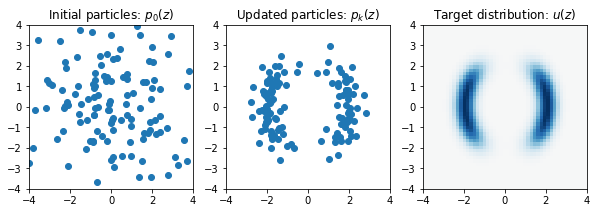

In [7]:
test_case(pot1)

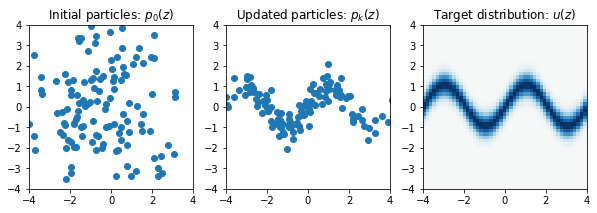

In [8]:
test_case(pot2)   